# **DOWNLOAD DATASETS**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [2]:
# ========================
# 0. Setup Style
# ========================
plt.style.use('classic')
sns.set_style("whitegrid")

# ========================
# 1. Load Dataset
# ========================
file_path = '/content/drive/MyDrive/DATASET PROJECT"/supply_chain_data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# **Data Understanding**

In [3]:
# ========================
# 2. Data Understanding
# ========================
print("\n📌 Info Data:")
print(df.info())

print("\n📌 Statistik Deskriptif:")
print(df.describe())

print("\n📌 Jumlah Missing Values:")
print(df.isnull().sum())

print("\n📌 Jumlah Duplikasi:")
print(df.duplicated().sum())


📌 Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location     

# **Data Cleaning & Standarisasi**

In [4]:
# ========================
# 3. Data Cleaning & Standarisasi
# ========================
# Standarisasi defect rate ke 0-100
if df['Defect rates'].max() <= 1:
    df['Defect rates'] *= 100

# Konversi waktu ke hari jika perlu
time_cols = ['Lead time', 'Shipping times', 'Manufacturing lead time']
for col in time_cols:
    if df[col].mean() > 30:
        df[col] = df[col] / 24

# Pastikan biaya tipe float
cost_cols = ['Price', 'Manufacturing costs', 'Shipping costs', 'Costs']
for col in cost_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle outlier (IQR)
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in ['Price', 'Defect rates', 'Lead time', 'Costs']:
    df = remove_outliers_iqr(df, col)

print("✅ Shape setelah outlier removal:", df.shape)

✅ Shape setelah outlier removal: (100, 24)


# **Feature Engineering KPI**

In [5]:
# ========================
# 4. Feature Engineering KPI
# ========================
df['On_Time_Delivery_Rate'] = (df['Shipping times'] / df['Lead time']).clip(upper=1)
df['Reliability_Score'] = 100 - df['Defect rates']
df['Total_Cost'] = df['Manufacturing costs'] + df['Shipping costs'] + df['Costs']
df['Cost_Efficiency'] = 1 - (df['Total_Cost'] / df['Total_Cost'].max())
df['Production_Capacity_Score'] = df['Production volumes'] / df['Production volumes'].max()

# Supplier Score
df['Supplier_Score'] = (
    df['On_Time_Delivery_Rate'] * 0.35 +
    (df['Reliability_Score'] / 100) * 0.35 +
    df['Cost_Efficiency'] * 0.20 +
    df['Production_Capacity_Score'] * 0.10
) * 100

# Kategori Supplier
def classify_supplier(score):
    if score >= 85:
        return "Preferred"
    elif score >= 70:
        return "Standard"
    else:
        return "High Risk"

df['Supplier_Category'] = df['Supplier_Score'].apply(classify_supplier)

# Simpan data bersih
clean_file_path = '/content/drive/MyDrive/DATASET PROJECT"/supply_chain_data_cleaned.csv'
df.to_csv(clean_file_path, index=False)
print("💾 Data bersih disimpan di:", clean_file_path)

💾 Data bersih disimpan di: /content/drive/MyDrive/DATASET PROJECT"/supply_chain_data_cleaned.csv


# **Analisis Deskriptif (distribusi, kategori)**

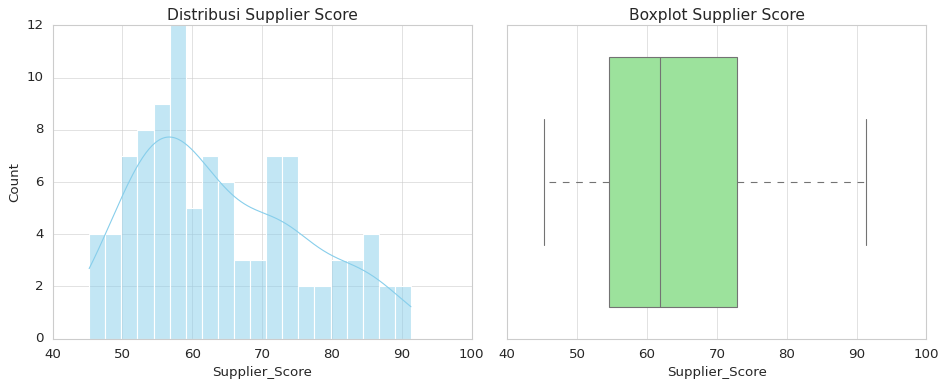

/tmp/ipython-input-3710214422.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Supplier_Category', palette='pastel', order=['Preferred', 'Standard', 'High Risk'])


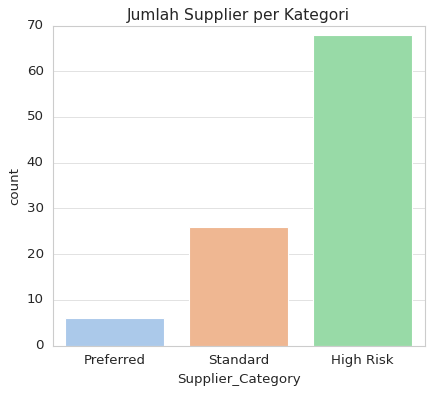

In [6]:
# ========================
# 5. Visualisasi Distribusi Score
# ========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['Supplier_Score'], bins=20, kde=True, color='skyblue')
plt.title("Distribusi Supplier Score", fontsize=14)

plt.subplot(1,2,2)
sns.boxplot(x=df['Supplier_Score'], color='lightgreen')
plt.title("Boxplot Supplier Score", fontsize=14)

plt.tight_layout()
plt.show()

# ========================
# 6. Komposisi Kategori
# ========================
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='Supplier_Category', palette='pastel', order=['Preferred', 'Standard', 'High Risk'])
plt.title("Jumlah Supplier per Kategori", fontsize=14)
plt.show()

# **Analisis Performa Top Supplier**

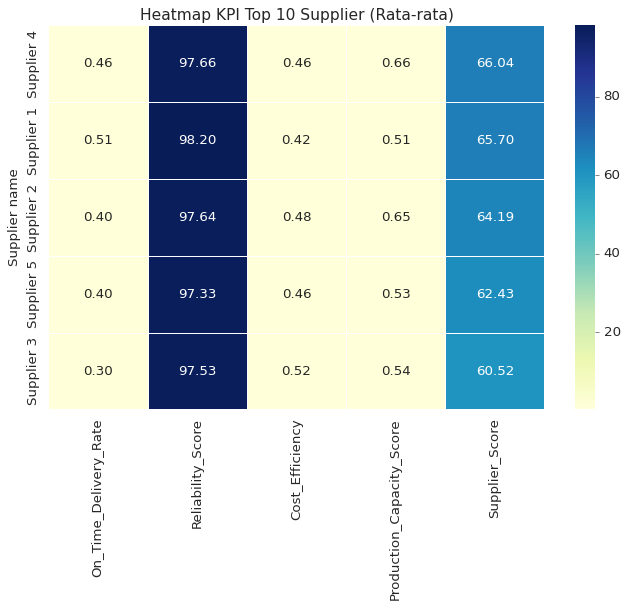

In [7]:
# ========================
# 7. Heatmap KPI Top 10 (Agregat)
# ========================
kpi_cols = [
    'On_Time_Delivery_Rate',
    'Reliability_Score',
    'Cost_Efficiency',
    'Production_Capacity_Score',
    'Supplier_Score'
]

# Rata-rata KPI per supplier
df_supplier_avg = df.groupby('Supplier name', as_index=False)[kpi_cols].mean()

# Top 10 Supplier unik
top_suppliers = df_supplier_avg.nlargest(10, 'Supplier_Score')

plt.figure(figsize=(10,6))
sns.heatmap(
    top_suppliers.set_index('Supplier name')[kpi_cols],
    annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5
)
plt.title("Heatmap KPI Top 10 Supplier (Rata-rata)", fontsize=14)
plt.show()

# **Insight & Rekomendasi**

In [8]:
# ========================
# 8. Insight Otomatis Lengkap
# ========================
best_supplier = top_suppliers.iloc[0]['Supplier name']
best_score = top_suppliers.iloc[0]['Supplier_Score']

avg_kpi = top_suppliers[kpi_cols].mean().sort_values(ascending=False)
best_kpi = avg_kpi.index[0]
worst_kpi = avg_kpi.index[-1]

best_ontime = top_suppliers.loc[top_suppliers['On_Time_Delivery_Rate'].idxmax(), 'Supplier name']
best_cost_eff = top_suppliers.loc[top_suppliers['Cost_Efficiency'].idxmax(), 'Supplier name']
worst_reliability = top_suppliers.loc[top_suppliers['Reliability_Score'].idxmin(), 'Supplier name']

print("\n=== INSIGHT OTOMATIS TOP 10 SUPPLIER ===")
print(f"1️⃣ Supplier dengan skor tertinggi: {best_supplier} ({best_score:.2f})")
print(f"2️⃣ KPI paling kuat di Top 10: {best_kpi} (rata-rata tertinggi)")
print(f"3️⃣ KPI paling lemah di Top 10: {worst_kpi} (rata-rata terendah)")
print(f"4️⃣ Supplier dengan On-Time Delivery Rate tertinggi: {best_ontime}")
print(f"5️⃣ Supplier dengan Cost Efficiency tertinggi: {best_cost_eff}")
print(f"6️⃣ Supplier dengan Reliability terendah: {worst_reliability}")
print(f"7️⃣ Rata-rata skor Top 10 Supplier: {top_suppliers['Supplier_Score'].mean():.2f}")



=== INSIGHT OTOMATIS TOP 10 SUPPLIER ===
1️⃣ Supplier dengan skor tertinggi: Supplier 4 (66.04)
2️⃣ KPI paling kuat di Top 10: Reliability_Score (rata-rata tertinggi)
3️⃣ KPI paling lemah di Top 10: On_Time_Delivery_Rate (rata-rata terendah)
4️⃣ Supplier dengan On-Time Delivery Rate tertinggi: Supplier 1
5️⃣ Supplier dengan Cost Efficiency tertinggi: Supplier 3
6️⃣ Supplier dengan Reliability terendah: Supplier 5
7️⃣ Rata-rata skor Top 10 Supplier: 63.77


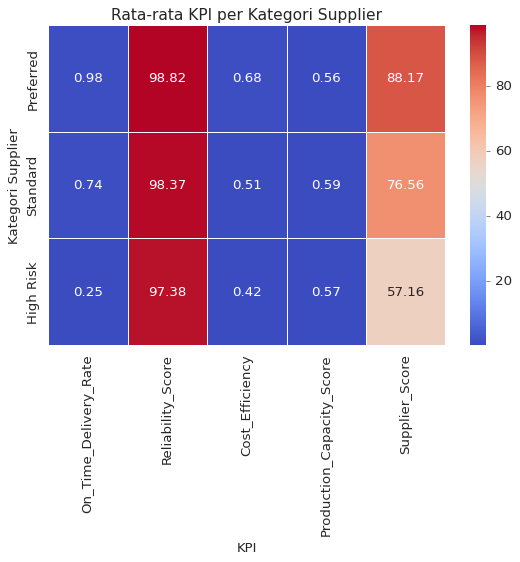

In [9]:
# ========================
# 9. Heatmap KPI per Kategori Supplier
# ========================
plt.figure(figsize=(8,5))
df_category_avg = df.groupby('Supplier_Category')[kpi_cols].mean().reindex(['Preferred', 'Standard', 'High Risk'])

sns.heatmap(
    df_category_avg,
    annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5
)
plt.title("Rata-rata KPI per Kategori Supplier", fontsize=14)
plt.ylabel("Kategori Supplier")
plt.xlabel("KPI")
plt.show()
